In [1]:
import sys
import string

from flowmaps.flowmaps import FlowMaps
from flowmaps import plot

import pytz
from datetime import datetime, timezone, timedelta

import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from scipy.stats import linregress

import seaborn as sns
import matplotlib.pyplot as plt

def compare_ine2mitma(date):
    df_mitma_odm = get_mitma_odm(date)
    df_ine_odm = get_ine_odm(date)
    
    mitma_ids = set(df_ine2mitma.mitma_id)
    mask = df_mitma_odm['target'].isin(mitma_ids) & df_mitma_odm['source'].isin(mitma_ids)
    df_mitma_odm = df_mitma_odm[mask]

    ine_ids = set(df_ine2mitma.index)
    mask = df_ine_odm['source'].isin(ine_ids) & df_ine_odm['target'].isin(ine_ids)
    df_ine_odm = df_ine_odm[mask]

    for i in ['source', 'target']:
        df_ine_odm = pd.merge(df_ine_odm, df_ine2mitma, left_on=i, right_index=True)
        df_ine_odm = df_ine_odm.drop(i, axis=1).rename({'mitma_id': i}, axis=1)
    df_ine_odm = df_ine_odm[['source', 'target', 'trips']]
    
    ine_odm_dict = {}
    for i,j,t in df_ine_odm[['source', 'target', 'trips']].values:
        ine_odm_dict[(i,j)] = t

    mitma_odm_dict = {}
    for i,j,t in df_mitma_odm[['source', 'target', 'trips']].values:
        mitma_odm_dict[(i,j)] = t

    common_od = set(ine_odm_dict.keys()) & set(mitma_odm_dict.keys())

    data = []
    for i,j in common_od:
        ine_t = ine_odm_dict[(i,j)]
        mitma_t = mitma_odm_dict[(i,j)]
        data.append([i, j, mitma_t, ine_t])

    df_odm_compare = pd.DataFrame(data, columns=['source', 'target', 'mitma_trips', 'ine_trips'])
    return df_odm_compare


def aggregate_by_geolayer(df, zones_mapping, col_name):
    if col_name not in {'cod_prov', 'cod_ca'}:
        return df
    df = df.copy()
    for i in ['source', 'target']:
        df = pd.merge(df, zones_mapping[col_name], left_on=i, right_index=True)
        df = df.drop(i, axis=1).rename({col_name: i}, axis=1)
        df = df[['source', 'target', 'mitma_trips', 'ine_trips']]
    df = df.groupby(['source', 'target']).aggregate({'mitma_trips': sum, 'ine_trips': sum}).reset_index()
    return df

def get_date(date_strn):
    date = datetime.strptime(date_strn, '%Y-%m-%d')
    start_summer_time = datetime(date.year, 3, 29)
    end_summer_time = datetime(date.year, 10, 25)
    if start_summer_time <= date <= end_summer_time:
        delta_h = timedelta(hours=2)
    else:
        delta_h =  timedelta(hours=1)
    date -= delta_h
    return date

def RMSE(x, y):
    return np.sqrt(((x - y) ** 2).mean())


## Comapring data respect to INE

In [2]:
# Requires pyflowmaps
def get_mitma_odm(date):
    filters = {'date': date, 'source_layer': 'mitma_mov', 'target_layer': 'mitma_mov' }
    projection = { 'source': 1, 'target': 1, 'trips': 1 }
    df = fm.data('mitma_mov.daily_mobility_matrix').filter(filters).project(projection).get().to_df()
    return df


# Requires pyflowmaps
def get_ine_odm(date_strn):
    date = get_date(date_strn)
    filters = {'evday': date }
    projection = {'_id':0, 'origen': 1, 'destino': 1, 'flujo': 1 }
    df = fm.data('ine_mov.movements').filter(filters).project(projection).get().to_df()
    df = df.rename({'origen':'source', 'destino':'target', 'flujo':'trips'}, axis=1)
    return df


# Requires pyflowmaps
def get_mitma_zones():
    
    muni2trans = fm.query('mitma_mov.muni2trans').get().to_df()
    muni2trans = muni2trans[['id_grupo_t', 'cpro']].drop_duplicates()
    cnig_provincia = fm.query('cnig.provincias').get().to_df().drop('_id', axis=1)
    
    mitma_zones = fm.layer('mitma_mov').get().to_df()
    mitma_geojson_dict = dict(zip(mitma_zones['id'], mitma_zones['feat']))
    mitma_zones['x'] = mitma_zones.centroid.map(lambda x: x[0])
    mitma_zones['y'] = mitma_zones.centroid.map(lambda x: x[1])
    mitma_zones = mitma_zones.drop(['feat', 'centroid', '_id', 'layer'], axis=1)
    mitma_zones = mitma_zones.sort_index()
    mitma_zones = pd.merge(mitma_zones, muni2trans, left_on='id', right_on='id_grupo_t')
    mitma_zones = pd.merge(mitma_zones, cnig_provincia, left_on='cpro', right_on='cod_prov').set_index('id')
    
    return mitma_zones


tz = pytz.timezone('Europe/Madrid')

mongodb_params = {
    "host": ['mdb-login.bsc.es:27017'],
    "username":'flowmaps_ro',
    "password": 'ifB8e2ECz7EFK5a4Jyja',
    "authSource": 'FlowMaps'
}

fm = FlowMaps(mongodb_params)
zones_mapping = get_mitma_zones()



In [3]:
# requires pyflowmaps
cursor = fm.overlaps('mitma_mov', 'ine_mov', layer1_min_ratio=0.9).get()
df_ine2mitma = cursor.to_df()

df_ine2mitma = df_ine2mitma[['id1','id2']].rename({'id1':'mitma_id', 'id2': 'ine_id'}, axis=1)
df_ine2mitma = df_ine2mitma.set_index('ine_id')

selected_dates = ['2020-03-20', '2020-04-20', '2020-05-20', '2020-06-20']
odm_compare_dict = {}
for date in selected_dates:
    print(date)
    odm_compare_dict[date] = compare_ine2mitma(date)

2020-03-20
2020-04-20
2020-05-20
2020-06-20


district
	2020-03-20  R^2 0.79  p-value 0.00E+00  N=20252 slope=9.52
	2020-04-20  R^2 0.80  p-value 0.00E+00  N=19854 slope=10.40
	2020-05-20  R^2 0.82  p-value 0.00E+00  N=28862 slope=10.20
	2020-06-20  R^2 0.83  p-value 0.00E+00  N=33220 slope=10.05
cod_prov
	2020-03-20  R^2 0.99  p-value 3.56E-209  N=213 slope=11.86
	2020-04-20  R^2 1.00  p-value 4.51E-218  N=217 slope=12.94
	2020-05-20  R^2 1.00  p-value 1.46E-242  N=238 slope=11.69
	2020-06-20  R^2 1.00  p-value 1.33E-247  N=243 slope=11.23
cod_ca
	2020-03-20  R^2 1.00  p-value 3.13E-79  N=74 slope=11.60
	2020-04-20  R^2 1.00  p-value 5.36E-80  N=74 slope=12.27
	2020-05-20  R^2 1.00  p-value 4.07E-86  N=77 slope=11.17
	2020-06-20  R^2 1.00  p-value 8.63E-84  N=76 slope=10.70


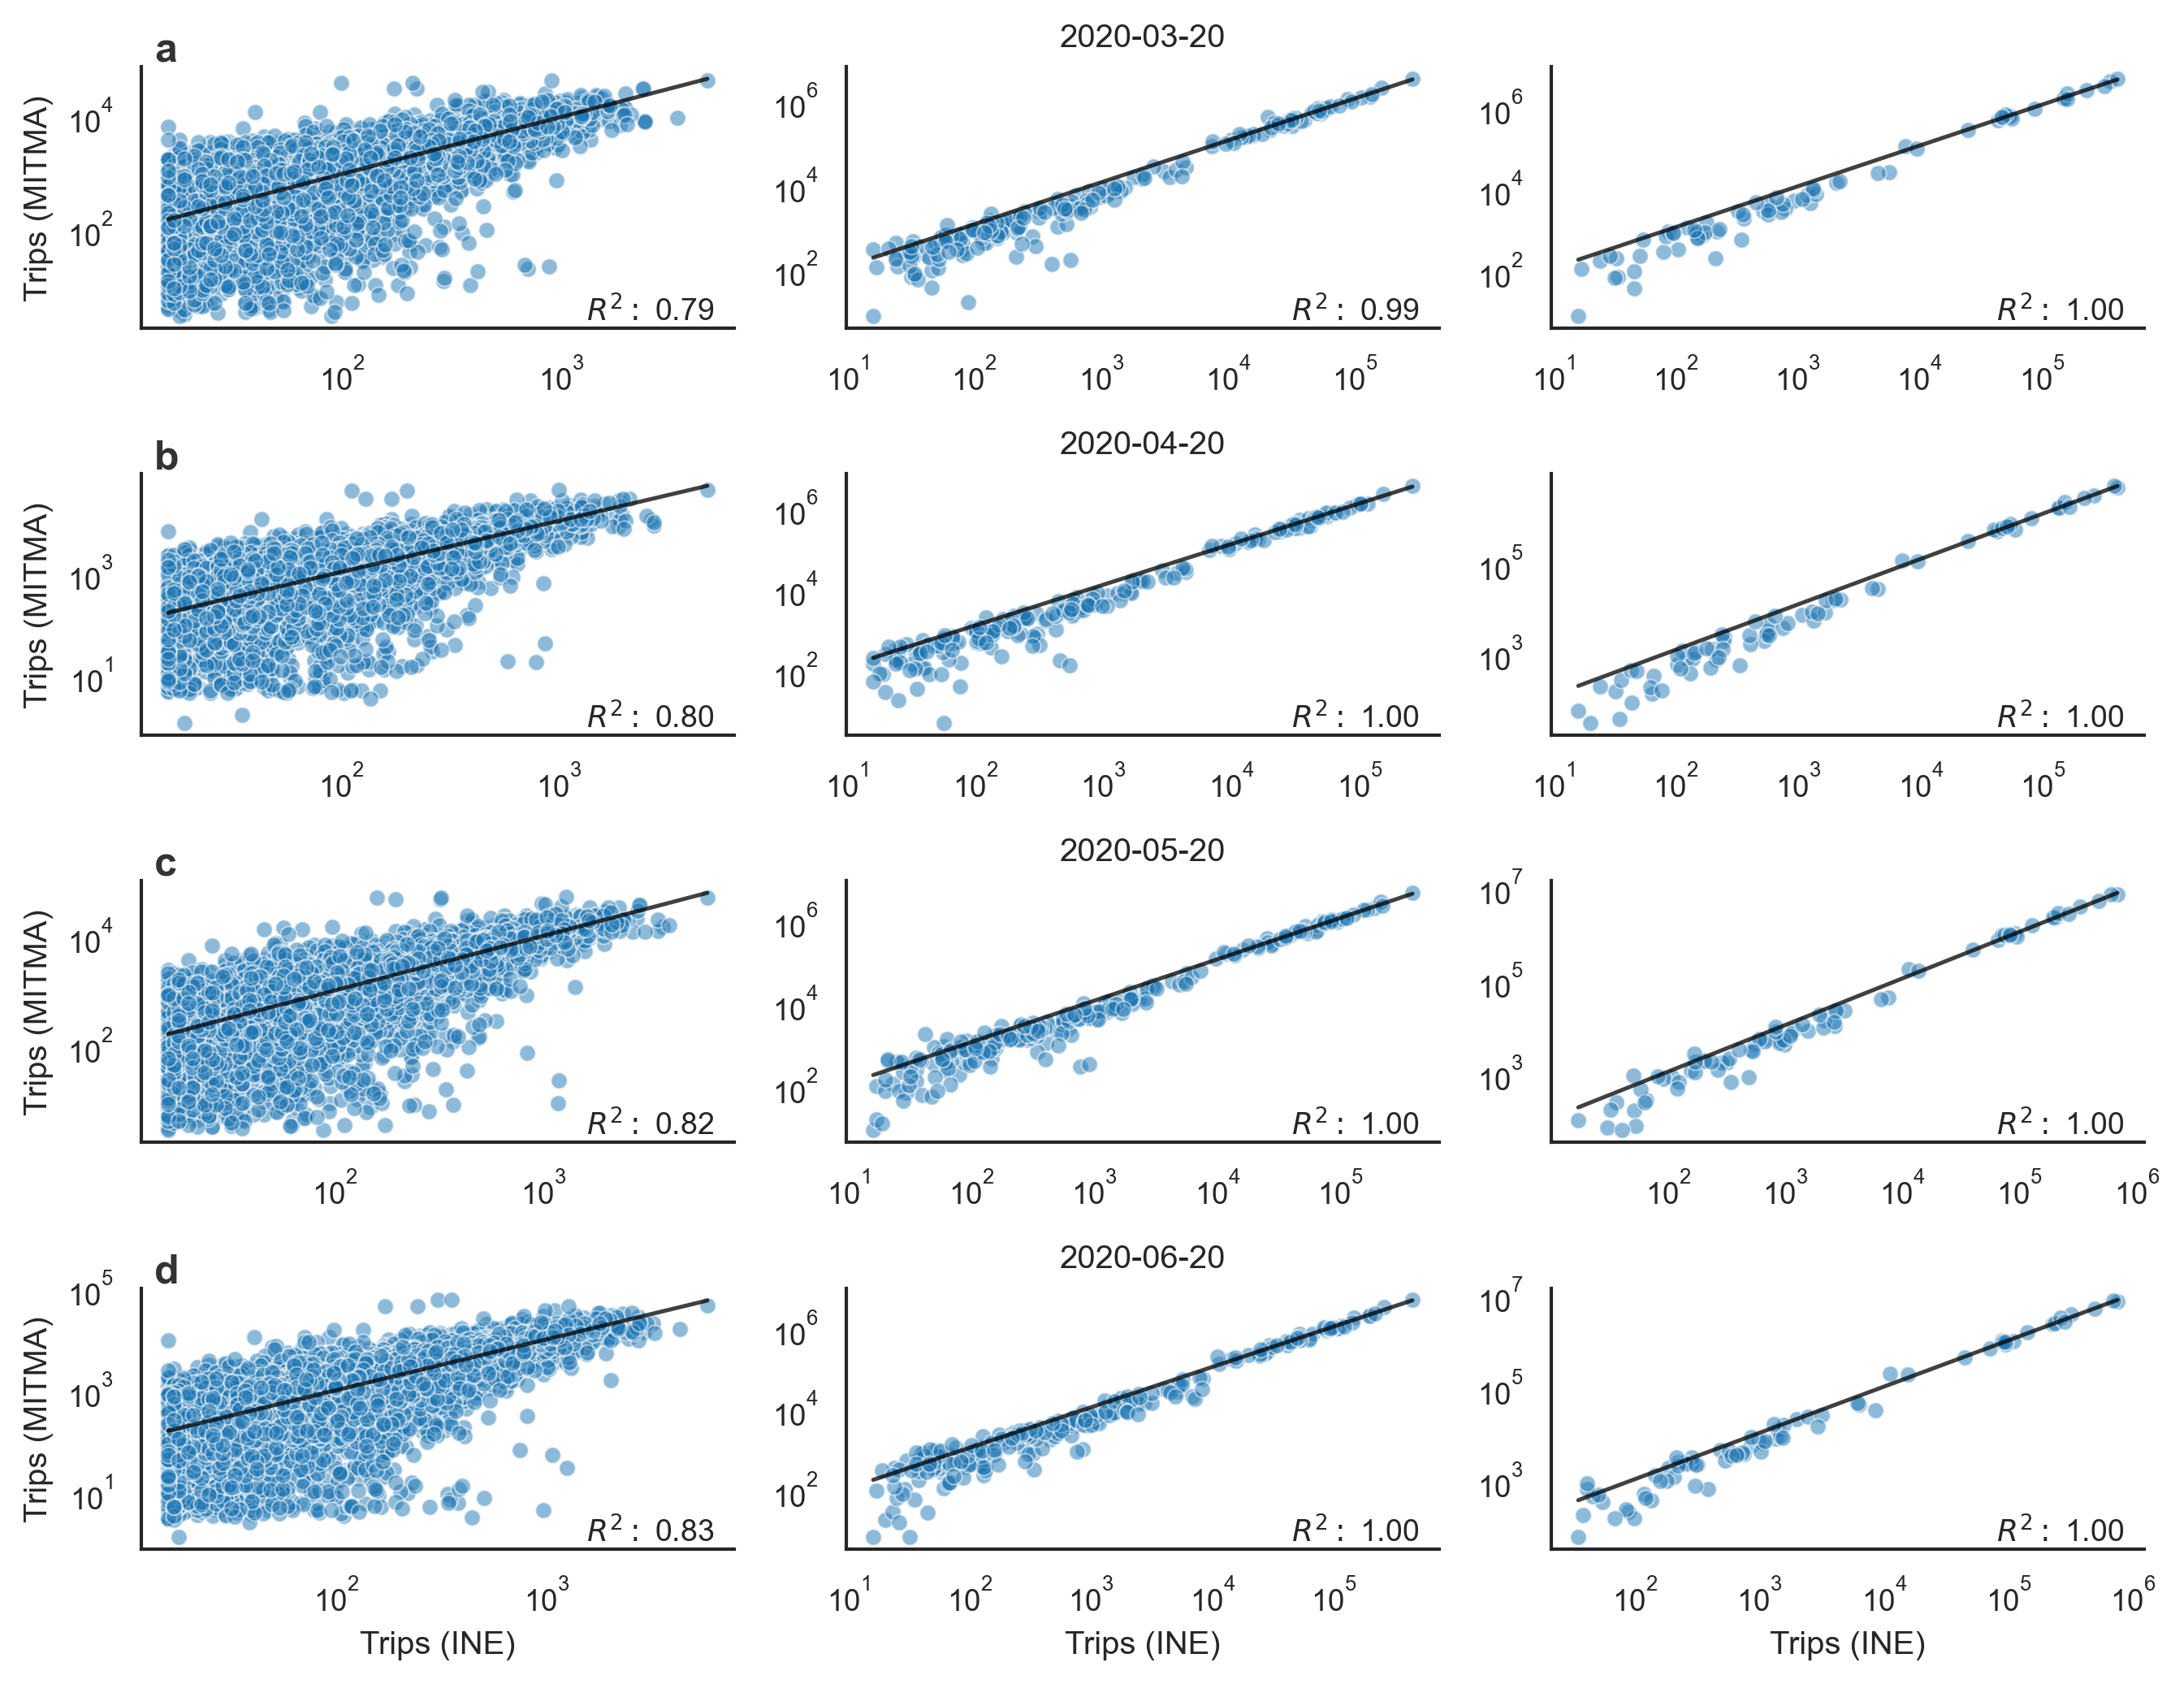

In [4]:
sns.set_style('white')
sns.set_context('paper')
fig, axes = plt.subplots(4,3, figsize=(9,7), dpi=300)

for j,geolayer in enumerate(['district', 'cod_prov', 'cod_ca']):
    print(geolayer)
    for i,date in enumerate(selected_dates):
        df_odm_compare = aggregate_by_geolayer(odm_compare_dict[date], zones_mapping, geolayer)
    
        X = df_odm_compare['ine_trips']
        y = df_odm_compare['mitma_trips']
        r,p = pearsonr(X, y)
        res = linregress(X, y)
        y_predicted = X * res.slope
        print("\t%s  R^2 %.2f  p-value %.2E  N=%i slope=%.2f" % (date, r, p, df_odm_compare.shape[0], res.slope))

        ax = axes[i,j]
        ax.scatter(X, y, alpha=0.5, edgecolor='w', linewidth=0.5)
        if i==3:
            ax.set_xlabel('Trips (INE)')
        if j==1:
            ax.set_title(date)
        if j==0:
            ax.set_ylabel('Trips (MITMA)')
            ax.text(0.022, 1.02, string.ascii_lowercase[i], fontsize=12, 
                transform=ax.transAxes, weight='bold', color='#333333')
        
        ax.plot(sorted(X), sorted(y_predicted), c='k', alpha=0.75)        
        ax.text(0.75, 0.028, r'$R^2:$ %.2f' % r, fontsize=9, transform=ax.transAxes)
        ax.set(xscale="log", yscale="log")
        
fig.tight_layout()
sns.despine(fig)
fig.savefig('../out/Figure_6.png')